In [1]:
import pandas as pd
import chart_studio
chart_studio.tools.set_credentials_file(username='username', api_key='api_key')
import chart_studio.plotly as py
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import *

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # For creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt


In [94]:
#파일 불러오기
file_path = '../Churn.xlsx'
data = pd.read_excel(file_path)

In [97]:
#문자화
data['Satisfaction Score'] = data['Satisfaction Score'].astype(str)

#더미 변수화
d_data = pd.get_dummies(data)
d_data.head()

,Age,Age Group,Number of Dependents,Tech services,Streaming services,Combined Product,Tenure in Months,Monthly Charge,Total Revenue,Churn Value,...,Membership_Offer D,Membership_Offer E,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5,Contract_Month-to-Month,Contract_One Year,Contract_Two Year
0,78,70,0,1,1,2,1,39.65,59.65,1,...,0,0,0,0,1,0,0,1,0,0
1,74,70,1,1,0,4,8,80.65,1024.10,1,...,0,1,0,0,1,0,0,1,0,0
2,71,70,3,0,2,4,18,95.45,1910.88,1,...,1,0,0,1,0,0,0,1,0,0
3,78,70,1,2,2,4,25,98.50,2995.07,1,...,0,0,0,1,0,0,0,1,0,0
4,80,80,1,0,0,4,37,76.50,3102.36,1,...,0,0,0,1,0,0,0,1,0,0


In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Churn Value 열을 타겟 변수로 설정. 종속 변수와 독립 변수 분리
y = d_data['Churn Value'].values
X = d_data.drop(columns=['Churn Value'])

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

# Standard 스케일링
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

#MinMax 스케일링
#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

#로버스트
scaler = RobustScaler().fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE 오버샘플링
over = SMOTE(sampling_strategy='auto', random_state=88)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_scaled, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_resampled.shape, y_train_resampled.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_resampled).value_counts())


SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (4930, 23) (4930,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (7220, 23) (7220,)
SMOTE 적용 후 레이블 값 분포: 
 0    3610
1    3610
dtype: int64


In [99]:
print(X_train_scaled)
print(X_train_scaled[0])

[[-0.03571429  0.          0.         ... -1.          1.
   0.        ]
 [ 0.53571429  0.66666667  0.         ...  0.          0.
   0.        ]
 [-0.71428571 -0.66666667  0.         ... -1.          0.
   1.        ]
 ...
 [ 0.28571429  0.33333333  0.         ...  0.          0.
   0.        ]
 [-0.32142857 -0.33333333  0.         ... -1.          0.
   1.        ]
 [ 0.35714286  0.33333333  3.         ...  0.          0.
   0.        ]]
[-0.03571429  0.          0.          0.5         0.         -0.33333333
  0.84782609 -0.28526005  0.66505932 -1.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.         -1.          1.          0.        ]


In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 로지스틱 회귀 모델 튜닝
lr_model = LogisticRegression(random_state=88)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

# 최적 하이퍼파라미터 출력
print("로지스틱 회귀 모델 최적 하이퍼파라미터:", grid_search.best_params_)

# 최적 모델로 재학습
best_lr_model = grid_search.best_estimator_
best_lr_model.fit(X_train_resampled, y_train_resampled)

# 테스트 데이터로 성능 평가
y_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
confusion_lr = confusion_matrix(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

print("로지스틱 회귀 모델 정확도:", accuracy_lr)
print("로지스틱 회귀 모델 혼동 행렬:\n", confusion_lr)
print("로지스틱 회귀 모델 분류 보고서:\n", report_lr)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

로지스틱 회귀 모델 최적 하이퍼파라미터: {'C': 10, 'penalty': 'l2'}
로지스틱 회귀 모델 정확도: 0.6838618078561287
로지스틱 회귀 모델 혼동 행렬:
 [[1038  526]
 [ 142  407]]
로지스틱 회귀 모델 분류 보고서:
               precision    recall  f1-score   support

           0       0.88      0.66      0.76      1564
           1       0.44      0.74      0.55       549

    accuracy                           0.68      2113
   macro avg       0.66      0.70      0.65      2113
weighted avg       0.76      0.68      0.70      2113



D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


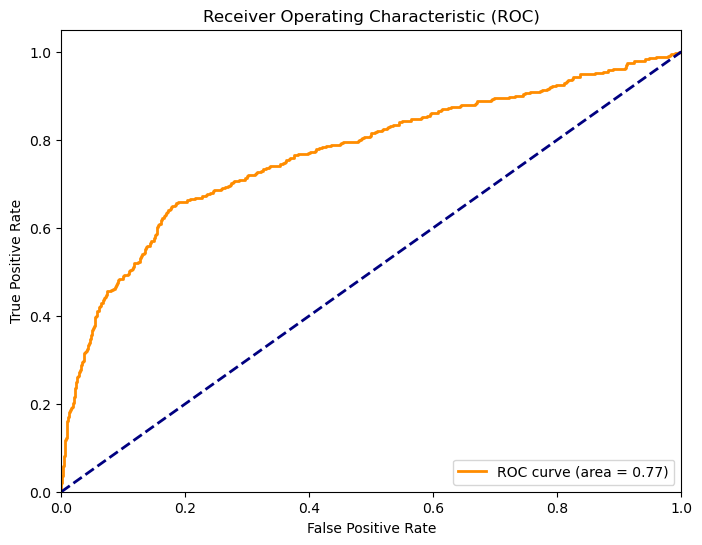

In [101]:
# ROC 곡선 그리기
y_score_lr = best_lr_model.decision_function(X_test)  # 로지스틱 회귀의 결정 함수 값
fpr, tpr, _ = roc_curve(y_test, y_score_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [102]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 데이터와 레이블을 준비
X = X_train_resampled
y = y_train_resampled

# 5-폴드 교차 검증을 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증을 통해 모델을 평가
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    scores.append(accuracy)

# 교차 검증 평균 정확도 출력
mean_accuracy = np.mean(scores)
print("5-폴드 교차 검증 평균 정확도:", mean_accuracy)

5-폴드 교차 검증 평균 정확도: 0.9344875346260387


In [103]:
# 폴드 교차 검증을 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 및 모델 평가
for train_index, test_index in kf.split(X):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]

    best_lr_model = grid_search.best_estimator_
    best_lr_model.fit(X_train, y_train)
    y_pred_lr = best_lr_model.predict(X_val)
    
    accuracy_lr = accuracy_score(y_val, y_pred_lr)
    confusion_lr = confusion_matrix(y_val, y_pred_lr)
    report_lr = classification_report(y_val, y_pred_lr)

    print("로지스틱 회귀 모델 정확도:", accuracy_lr)
    print("로지스틱 회귀 모델 혼동 행렬:\n", confusion_lr)
    print("로지스틱 회귀 모델 분류 보고서:\n", report_lr)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

로지스틱 회귀 모델 정확도: 0.9265927977839336
로지스틱 회귀 모델 혼동 행렬:
 [[682  58]
 [ 48 656]]
로지스틱 회귀 모델 분류 보고서:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       740
           1       0.92      0.93      0.93       704

    accuracy                           0.93      1444
   macro avg       0.93      0.93      0.93      1444
weighted avg       0.93      0.93      0.93      1444

로지스틱 회귀 모델 정확도: 0.9397506925207756
로지스틱 회귀 모델 혼동 행렬:
 [[679  36]
 [ 51 678]]
로지스틱 회귀 모델 분류 보고서:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       715
           1       0.95      0.93      0.94       729

    accuracy                           0.94      1444
   macro avg       0.94      0.94      0.94      1444
weighted avg       0.94      0.94      0.94      1444

로지스틱 회귀 모델 정확도: 0.932825484764543
로지스틱 회귀 모델 혼동 행렬:
 [[675  43]
 [ 54 672]]
로지스틱 회귀 모델 분류 보고서:
               precision    recall  f1-score   support

 

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


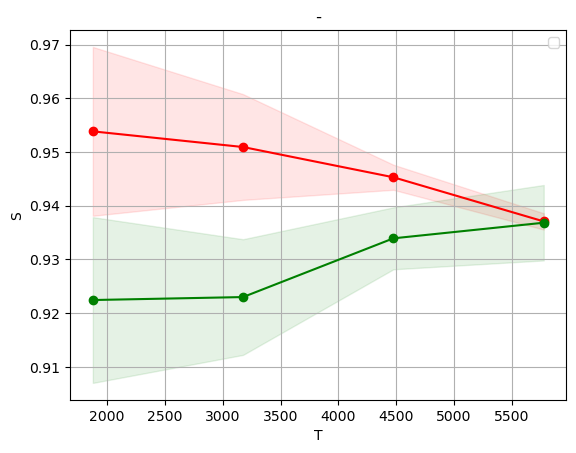

In [104]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 모델과 데이터를 사용하여 학습 곡선 그리기
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("T")
    plt.ylabel("S")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",)

    plt.legend(loc="best")
    return plt

# 학습 곡선 그리기
plot_learning_curve(best_lr_model,'-' , X_train_resampled, y_train_resampled, cv=5, n_jobs=4)

plt.show()

In [105]:
# 고객 데이터를 NumPy 배열로 변환 - 주의사항 : 전처리 된 값으로 넣어야 함
#customer_data = np.array([['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']] , dtype=np.float32)
customer_data = np.array([X_test_scaled[0]] , dtype=np.float32)

# 예측 수행
customer_pred = best_lr_model.predict(customer_data)

# 예측 확률 계산
customer_prob = best_lr_model.predict_proba(customer_data)


print("이탈확률:", customer_prob[0][1])

이탈확률: 0.0006601174440315294
